In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from torchvision import transforms
from network import resnet
from src import dataset
from tqdm import tqdm
from torch.optim import adam
import numpy as np
import math
import matplotlib.pyplot as plt


In [2]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, device="cpu", eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.device = device
        self.eps = eps
    
    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0-p)*(1-target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1-target).float()
        loss = - 1.0 * torch.pow((1-pt), self.gamma)*torch.log(pt+self.eps)
        return loss.sum()

In [3]:
num_classes = 1
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
network = resnet.resnet50(num_classes).to(device)
loss = nn.BCELoss().to(device)
transform =transforms.Compose([transforms.ToTensor()])
optimizer = adam.Adam(network.parameters(), lr=0.001, weight_decay=0.0001)

In [4]:
focal_loss = FocalLoss()

In [5]:
data_dir = "src/dataset/"
myDataSet = dataset.MyDataSet(data_dir, transform=transform)
total_ratio = 0.1
train_ratio = 0.05
val_ratio = 0.025
test_ratio = total_ratio - train_ratio - val_ratio

dataset_size = len(myDataSet)
train_size = int(dataset_size * train_ratio)
val_size = int(dataset_size * val_ratio)
test_size = int(dataset_size * test_ratio)
residual_size = dataset_size - train_size - val_size - test_size
train_dataset, val_dataset, test_dataset, _ = torch.utils.data.random_split(myDataSet, [train_size, val_size, test_size, residual_size])


In [6]:
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
epoch = 1
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
network.apply(init_weights)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
for _ in range(epoch):
    train_loss = 0.0
    for image, label in tqdm(train_dataloader):
        image = image.to(device)
        label = label.to(device).float()
        
        output = network(image)
        output = torch.sigmoid(output)
        
        batch_loss = loss(output, label)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.item()
    cost = train_loss/len(train_dataloader)
    print(cost)

100%|██████████| 441/441 [53:02<00:00,  7.22s/it] 

tensor(0.4670, grad_fn=<DivBackward0>)


In [7]:
with torch.no_grad():
    test_loss = 0.0
    for image, label in tqdm(test_dataloader):
        image = image.to(device)
        label = label.to(device).float()
        
        test_output = network(image)
        test_output = torch.sigmoid(test_output)
        
        batch_test_loss = loss(test_output, label)
        
        test_loss += batch_test_loss
    print(test_loss/len(test_dataloader))

100%|██████████| 220/220 [16:41<00:00,  4.55s/it]

tensor(0.3187)


In [8]:
def dft(img):
    array = torch.fft.fftshift(torch.fft.fft2(img, norm='ortho'))
    epsilon = 1e-12
    array = np.abs(array)
    array += epsilon
    array = np.log(array)
    
    return array

In [9]:
class sumNetwork(nn.Module):
    def __init__(self, dft, num_classes):
        super().__init__()
        self.src = resnet.resnetlayer18()
        self.tgt = resnet.resnetlayer18()
        self.dft = dft
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1*1*512, num_classes)
        
    def forward(self, x):
        y = dft(x)
        
        x = self.src(x)
        y = self.tgt(y)
        x = self.avgpool(x)
        y = self.avgpool(y)
        z = torch.flatten(x+y, start_dim=1)
        z = self.fc(z)
        return z
        
class concatNetwork(nn.Module):
    def __init__(self, dft, num_classes):
        super().__init__()
        self.src = resnet.resnetlayer18()
        self.tgt = resnet.resnetlayer18()
        self.dft = dft
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1*1*1024, num_classes)
        
    def forward(self, x):
        y = dft(x)
        
        x = self.src(x)
        y = self.tgt(y)
        x = self.avgpool(x)
        y = self.avgpool(y)
        z = torch.flatten(torch.cat((x,y), dim=1), start_dim=1)
        z = self.fc(z)
        return z
        

In [10]:
sumModel = sumNetwork(dft, num_classes)
sumModel.to(device)
sumModel.apply(init_weights)

sumNetwork(
  (src): ResNetLayer(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [11]:
concatModel = concatNetwork(dft, num_classes)
concatModel.to(device)
concatModel.apply(init_weights)

concatNetwork(
  (src): ResNetLayer(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

  0%|          | 0/220 [00:00<?, ?it/s]


TypeError: Invalid shape (3, 300, 300) for image data

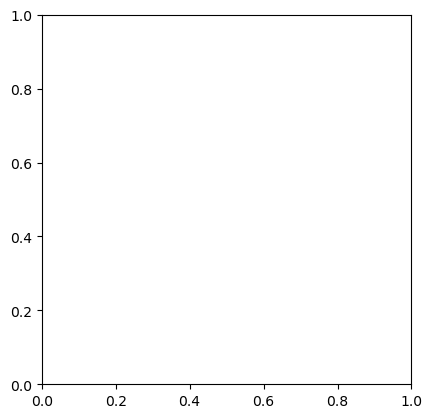

In [78]:
for _ in range(epoch):
    train_loss = 0.0
    for image, label in tqdm(train_dataloader):
        image = image.to(device)
        label = label.to(device).float()
        
        output = sumModel(image)
        output = torch.sigmoid(output)
        
        batch_loss = focal_loss(output, label)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.item()
    cost = train_loss/len(train_dataloader)
    print(cost)

In [12]:
def SequenceMask(X, X_len,value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen),dtype=torch.float)[None, :] < X_len[:, None]    
    X[~mask]=value
    return X

def masked_softmax(X, valid_length):
    # X: 3-D tensor, valid_length: 1-D or 2-D tensor
    softmax = nn.Softmax()
    if valid_length is None:
        return softmax(X)
    else:
        shape = X.shape
        if valid_length.dim() == 1:
            valid_length = torch.FloatTensor(valid_length.numpy().repeat(shape[1], axis=0))
        else:
            valid_length = valid_length.reshape((-1,))
        # fill masked elements with a large negative, whose exp is 0
        X = SequenceMask(X.reshape((-1, shape[-1])), valid_length)
        return softmax(X).reshape(shape)

class CrossAttention(nn.Module): 
    def __init__(self, dropout, **kwargs):
        super(CrossAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, valid_length=None):
        d = query.shape[-1]
        
        scores = torch.bmm(query, key.transpose(1,2)) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        return torch.bmm(attention_weights, value)
      
    

In [23]:
class customNetwork(nn.Module):
    def __init__(self, dft, attn, dimension, num_classes):
        super().__init__()
        self.src = resnet.resnetlayer18()
        self.tgt = resnet.resnetlayer18()
        self.Wk = nn.Sequential(nn.Linear(1*1, dimension), )
        self.Wq = nn.Sequential(nn.Linear(1*1, dimension), )
        self.Wv = nn.Sequential(nn.Linear(1*1, dimension), )
        self.dft = dft
        self.attn = attn
        self.classification = nn.Sequential(nn.LayerNorm(dimension), nn.Linear(dimension, num_classes))
        self.fc = nn.Linear(1*1*512, num_classes)
    def forward(self, x):
        y = dft(x)
        
        x = self.src(x)
        y = self.tgt(y)
        print(x.size())
        print(y.size())
        x = torch.flatten(x, dim=1)
        y = torch.flatten(y, dim=1)
        query = self.Wq(y)
        key = self.Wk(x)
        value = self.Wv(x)
        print(query.size())
        print(key.size())
        print(value.size())
        z = self.attn(query, key, value)
        z = torch.mean(z, dim=1)
        z = self.fc(z)
        return z
        

In [24]:

customModel = customNetwork(dft, CrossAttention(0.1),3, 1)
concatModel.to(device)
concatModel.apply(init_weights)

concatNetwork(
  (src): ResNetLayer(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [25]:
for _ in range(epoch):
    train_loss = 0.0
    for image, label in tqdm(train_dataloader):
        image = image.to(device)
        label = label.to(device).float()
        
        output = customModel(image)
        output = torch.sigmoid(output)
        
        batch_loss = focal_loss(output, label)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.item()
    cost = train_loss/len(train_dataloader)
    print(cost)

  0%|          | 0/220 [00:02<?, ?it/s]

torch.Size([16, 512, 10, 10])
torch.Size([16, 512, 10, 10])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (81920x10 and 1x3)